## Libraries
Code references: https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

In [2]:
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 8})

In [3]:
# Modelling and Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures

In [4]:
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")


Version skforecast: 0.16.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.6.0
Version pandas: 2.3.1
Version numpy: 2.0.2


## Prepare data

In [6]:
# Data download
# ==============================================================================
from skforecast.datasets import fetch_dataset
data = fetch_dataset(name='vic_electricity', raw=True)
data.info()

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [7]:
# Data preparation
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head(2)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


In [8]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")


Index complete: True
Number of rows with missing values: 0.0


In [9]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
data = data.drop(columns="Date")
data = (
    data
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data.head()


,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0


In [10]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00':'2014-12-30 23:00:00', :].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


In [11]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Demand'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Demand'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Demand'], mode='lines', name='Test'))
fig.update_layout(
    title='Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="Demand",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [12]:
data_val['Holiday'][:20]
# somehow 2014-01-01 14:00:00 is not marked as holiday, check sample data later

Time
2014-01-01 00:00:00    1.0
2014-01-01 01:00:00    1.0
2014-01-01 02:00:00    1.0
2014-01-01 03:00:00    1.0
2014-01-01 04:00:00    1.0
2014-01-01 05:00:00    1.0
2014-01-01 06:00:00    1.0
2014-01-01 07:00:00    1.0
2014-01-01 08:00:00    1.0
2014-01-01 09:00:00    1.0
2014-01-01 10:00:00    1.0
2014-01-01 11:00:00    1.0
2014-01-01 12:00:00    1.0
2014-01-01 13:00:00    1.0
2014-01-01 14:00:00    0.0
2014-01-01 15:00:00    0.0
2014-01-01 16:00:00    0.0
2014-01-01 17:00:00    0.0
2014-01-01 18:00:00    0.0
2014-01-01 19:00:00    0.0
Freq: h, Name: Holiday, dtype: float64

## Exog features

In [13]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = True,
)
calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

# Sunlight features
# ==============================================================================
location = LocationInfo(
    latitude  = -37.8,
    longitude = 144.95,
    timezone  = 'Australia/Melbourne'
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise']
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset']
    for date in data.index
]
sunrise_hour = pd.Series(sunrise_hour, index=data.index).dt.round("h").dt.hour
sunset_hour = pd.Series(sunset_hour, index=data.index).dt.round("h").dt.hour
sun_light_features = pd.DataFrame({
                        'sunrise_hour': sunrise_hour,
                        'sunset_hour': sunset_hour
                     })
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features["is_daylight"] = np.where(
    (data.index.hour >= sun_light_features["sunrise_hour"])
    & (data.index.hour < sun_light_features["sunset_hour"]),
    1,
    0,
)

# Holiday features
# ==============================================================================
holiday_features = data[['Holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['Holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['Holiday'].shift(-24)

# Rolling windows of temperature
# ==============================================================================
wf_transformer = WindowFeatures(
    variables   = ["Temperature"],
    window      = ["1D", "7D"],
    functions   = ["mean", "max", "min"],
    freq        = "h",
)
temp_features = wf_transformer.fit_transform(data[['Temperature']])


# Merge all exogenous variables
# ==============================================================================
assert all(calendar_features.index == sun_light_features.index)
assert all(calendar_features.index == temp_features.index)
assert all(calendar_features.index == holiday_features.index)
exogenous_features = pd.concat([
                         calendar_features,
                         sun_light_features,
                         temp_features,
                         holiday_features
                     ], axis=1)

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. And due to holiday_next_day there are missing values at the end.
exogenous_features = exogenous_features.iloc[7 * 24:, :]
exogenous_features = exogenous_features.iloc[:-24, :]
exogenous_features.head(3)


,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,Temperature,Temperature_window_1D_mean,Temperature_window_1D_max,Temperature_window_1D_min,Temperature_window_7D_mean,Temperature_window_7D_max,Temperature_window_7D_min,Holiday,holiday_previous_day,holiday_next_day
Time,,,,,,,,,,,,,,,,,,
2012-01-08 00:00:00,1,1,6,0,6,21,15,0,20.575,24.296875,29.0,19.875,23.254018,39.525,14.35,0,0.0,0.0
2012-01-08 01:00:00,1,1,6,1,6,21,15,0,22.500,24.098958,29.0,19.875,23.215774,39.525,14.35,0,0.0,0.0
2012-01-08 02:00:00,1,1,6,2,6,21,15,0,25.250,23.923958,29.0,19.875,23.173214,39.525,14.35,0,0.0,0.0


In [14]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
    "sunrise_hour",
    "sunset_hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 6,
    "hour": 24,
    "sunrise_hour": 24,
    "sunset_hour": 24,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

exogenous_features = cyclical_encoder.fit_transform(exogenous_features)
exogenous_features.head(3)


,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,Temperature,Temperature_window_1D_mean,...,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,sunrise_hour_sin,sunrise_hour_cos,sunset_hour_sin,sunset_hour_cos
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-08 00:00:00,1,1,6,0,6,21,15,0,20.575,24.296875,...,0.120537,0.992709,-2.449294e-16,1.0,0.000000,1.000000,1.0,6.123234e-17,-0.707107,0.707107
2012-01-08 01:00:00,1,1,6,1,6,21,15,0,22.500,24.098958,...,0.120537,0.992709,-2.449294e-16,1.0,0.258819,0.965926,1.0,6.123234e-17,-0.707107,0.707107
2012-01-08 02:00:00,1,1,6,2,6,21,15,0,25.250,23.923958,...,0.120537,0.992709,-2.449294e-16,1.0,0.500000,0.866025,1.0,6.123234e-17,-0.707107,0.707107


In [15]:
# # Interaction between exogenous variables
# # ==============================================================================
# transformer_poly = PolynomialFeatures(
#                         degree           = 2,
#                         interaction_only = True,
#                         include_bias     = False
#                     ).set_output(transform="pandas")
# poly_cols = [
#     'month_sin', 
#     'month_cos',
#     'week_sin',
#     'week_cos',
#     'day_of_week_sin',
#     'day_of_week_cos',
#     'hour_sin',
#     'hour_cos',
#     'sunrise_hour_sin',
#     'sunrise_hour_cos',
#     'sunset_hour_sin',
#     'sunset_hour_cos',
#     'daylight_hours',
#     'is_daylight',
#     'holiday_previous_day',
#     'holiday_next_day',
#     'Temperature_window_1D_mean',
#     'Temperature_window_1D_min',
#     'Temperature_window_1D_max',
#     'Temperature_window_7D_mean',
#     'Temperature_window_7D_min',
#     'Temperature_window_7D_max',
#     'Temperature',
#     'Holiday'
# ]
# poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols])
# poly_features = poly_features.drop(columns=poly_cols)
# poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
# poly_features.columns = poly_features.columns.str.replace(" ", "__")
# assert all(poly_features.index == exogenous_features.index)
# exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)
# exogenous_features.head(3)


In [16]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
# Columns that start with temp_ are selected
exog_features.extend(exogenous_features.filter(regex='^Temperature_.*').columns.tolist())
# Columns that start with holiday_ are selected
exog_features.extend(exogenous_features.filter(regex='^Holiday_.*').columns.tolist())
# Include original features
exog_features.extend(['Temperature', 'Holiday'])


In [17]:
exog_features

['month_sin',
 'month_cos',
 'week_sin',
 'week_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'hour_sin',
 'hour_cos',
 'sunrise_hour_sin',
 'sunrise_hour_cos',
 'sunset_hour_sin',
 'sunset_hour_cos',
 'Temperature_window_1D_mean',
 'Temperature_window_1D_max',
 'Temperature_window_1D_min',
 'Temperature_window_7D_mean',
 'Temperature_window_7D_max',
 'Temperature_window_7D_min',
 'Temperature',
 'Holiday']

In [18]:
# Merge target and exogenous variables in the same DataFrame
# ==============================================================================
data = data[['Demand']].merge(
           exogenous_features[exog_features],
           left_index  = True,
           right_index = True,
           how         = 'inner'  # Use only dates for which we have all the variables
       )
data = data.astype('float32')

# Split data into train-val-test
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()


## Model - Forecaster Recursive

In [19]:
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                 lags            = 24,
                 window_features = window_features,                 
             )

In [20]:
forecaster.fit(
    y = data_train['Demand'],
    exog=data_train[exog_features])

In [21]:
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Series name: Demand 
Exogenous included: True 
Exogenous names: 
    month_sin, month_cos, week_sin, week_cos, day_of_week_sin, day_of_week_cos,
    hour_sin, hour_cos, sunrise_hour_sin, sunrise_hour_cos, sunset_hour_sin,
    sunset_hour_cos, Temperature_window_1D_mean, Temperature_window_1D_max,
    Temperature_window_1D_min, Temperature_window_7D_mean,
    Temperature_window_7D_max, Temperature_window_7D_min, Temperature, Holiday 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2012-01-08 00:00:00'), Timestamp('2013-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-10-12 16:49:38 
Last fit date: 2025-10-12 16:49:39 
Skforecast version: 0.16.0 
Python version: 3.9.6 
Forecaster id: None

In [22]:
forecaster.last_window_

,Demand
Time,
2013-12-29 00:00:00,3530.617676
2013-12-29 01:00:00,3539.066162
2013-12-29 02:00:00,3541.401611
2013-12-29 03:00:00,3482.240479
2013-12-29 04:00:00,3472.748535
...,...
2013-12-31 19:00:00,3021.970947
2013-12-31 20:00:00,3054.708496
2013-12-31 21:00:00,3179.705322


In [23]:
forecaster.index_freq_

'h'

In [24]:
cv_test = TimeSeriesFold(
         steps                 = 24,
        #  initial_train_size    = len(data.loc[:end_train]),
         window_size           = 72,
        #  refit                 = True,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

# cv.split(X=data_test, as_pandas=True)
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          exog          = data_test[exog_features],
                          y             = data_test['Demand'],
                          cv            = cv_test,
                          metric        = ['mean_squared_error', 'mean_absolute_error'],
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
An already trained forecaster is to be used. Window size: 72
Number of observations used for backtesting: 624
    Number of folds: 26
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   No training in this fold
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 1
    Training:   No training in this fold
    Validation: 2014-12-05 00:00:00 -- 2014-12-05 23:00:00  (n=24)
Fold: 2
    Training:   No training in this fold
    Validation: 2014-12-06 00:00:00 -- 2014-12-06 23:00:00  (n=24)
Fold: 3
    Training:   No training in this fold
    Validation: 2014-12-07 00:00:00 -- 2014-12-07 23:00:00  (n=24)
Fold: 4
    Training:   No training in this fold
    Validation: 2014-12-08 00:00:00 -- 2014-12-08 23:00:00  (n=24)
Fold: 5
    Training:   No training in this fold
    Validation: 2014-12-09 00:00:00

  0%|          | 0/26 [00:00<?, ?it/s]

In [25]:
metric

,mean_squared_error,mean_absolute_error
0,44330.968951,143.216853


## Using ForecastVerifier

In [26]:
from forecast_verifier.model import Forecaster
from forecast_verifier.dataset import PerturbationDataset
from forecast_verifier.verifier import Verifier
from forecast_verifier.graph import PerturbationDirection, EffectDirection

class MyModel(Forecaster):

    def __init__(self, 
                 model: ForecasterRecursive, 
                 step: int):
        
        self.model = model
        self.step = step
        
    def _create_cv(self):
        cv = TimeSeriesFold(
         steps                 = self.step,         
         window_size           = self.model.window_size,
         refit                 = False,         
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )
        return cv
    

    def forecast(self, dataset: pd.DataFrame):

        # cv.split(X=data_test, as_pandas=True)
        metric, predictions = backtesting_forecaster(
                                forecaster    = self.model,
                                exog          = dataset[self.model.exog_names_in_],
                                y             = dataset[forecaster.series_name_in_],
                                cv            = self._create_cv(),
                                metric        = 'mean_squared_error',
                                n_jobs        = 'auto',
                                verbose       = False,
                                show_progress = True)
        return predictions['pred']

In [27]:
my_model = MyModel(forecaster, 24)

In [28]:

original_data = data_test.copy()

In [ ]:
## iterate with different magnitudes of perturbation
result_list = []
for percent_factor in np.arange(0.1, 0.9, 0.1):
    for direction in [PerturbationDirection.decreasing, PerturbationDirection.increasing]:
        
        perturbation_data = PerturbationDataset(original_data, ['Temperature'], perturbation_direction=direction)
        perturbation_data = perturbation_data.multipicative_perturb(percent_factor, bound=(-10, 40)) # decrease temperature by a%, but not below -10 or above 40
        verifier = Verifier(my_model, original_data, perturbation_data, ['Temperature'], direction, EffectDirection.positive)
        results = verifier()
        result_list.append({'change' : 1 + percent_factor*direction.value, 'alignment_score': results['alignment_score']})
    

In [30]:
result_list

[{'change': np.float64(0.9),
  'alignment_score': np.float64(0.6971153846153846)},
 {'change': np.float64(1.1),
  'alignment_score': np.float64(0.8477564102564102)},
 {'change': np.float64(0.8),
  'alignment_score': np.float64(0.5993589743589743)},
 {'change': np.float64(1.2),
  'alignment_score': np.float64(0.9198717948717948)},
 {'change': np.float64(0.7),
  'alignment_score': np.float64(0.4358974358974359)},
 {'change': np.float64(1.3),
  'alignment_score': np.float64(0.9439102564102564)},
 {'change': np.float64(0.6),
  'alignment_score': np.float64(0.32211538461538464)},
 {'change': np.float64(1.4),
  'alignment_score': np.float64(0.9615384615384616)},
 {'change': np.float64(0.5),
  'alignment_score': np.float64(0.2532051282051282)},
 {'change': np.float64(1.5),
  'alignment_score': np.float64(0.9791666666666666)},
 {'change': np.float64(0.4),
  'alignment_score': np.float64(0.20352564102564102)},
 {'change': np.float64(1.6),
  'alignment_score': np.float64(0.9823717948717948)},
 {

<Axes: xlabel='change'>

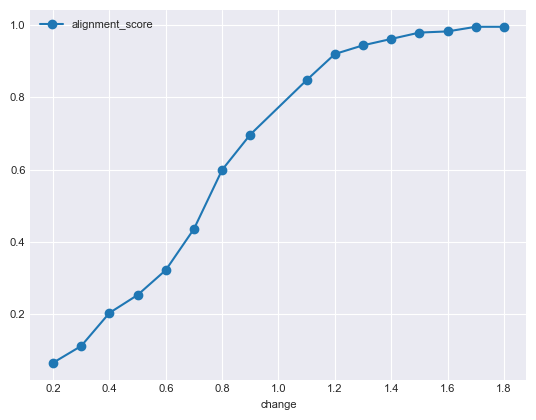

In [31]:
pd.DataFrame(result_list).sort_values('change').plot(x='change', y='alignment_score', marker='o')

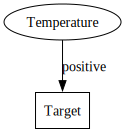

In [32]:
verifier.assumption_plot()

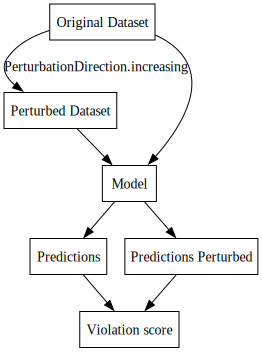

In [33]:
verifier.procedure_plot()

### Binary

In [34]:
perturbation_data_list = PerturbationDataset(original_data, ['Holiday'], perturbation_direction=PerturbationDirection.binary)
perturbation_data_list = perturbation_data_list.binary_perturb()

In [35]:
verifier = Verifier(my_model, perturbation_data_list[0], perturbation_data_list[1], ['Holiday'], PerturbationDirection.binary, EffectDirection.positive)

In [36]:
verifier()

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

/Users/maichi/KULeuven/job-student/summer-project/forecast-verifier/env/lib/python3.9/site-packages/forecast_verifier/metrics.py:57: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



{'assumption': "['Holiday'] → target",
 'relationship': 'EffectDirection.positive',
 'perturbation_direction': <PerturbationDirection.binary: 0>,
 'alignment_score': np.float64(0.0),
 'target_length': 624}

In [37]:
perturbation_data_list[0]['Holiday'].unique()

array([0.])

In [38]:
perturbation_data_list[1]['Holiday'].unique()

array([1.])

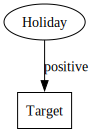

In [39]:
verifier.assumption_plot()